In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gekko import GEKKO
from lib import *

In [2]:
%load_ext autoreload
%autoreload 2

## Problem

Suppose we have state variable $x \in \mathbb{R}$ and **binary** control variable $i$ (i.e. it's just a switch with modes "off" = 0 and "on" = 1). Both depend on time $t$. We need to find such a solution

$$ 
F(\textbf{x}, \textbf{i}) \rightarrow
\min\limits_{\textbf{x}, \textbf{i}}
, \quad
\text{such that} \;\;
\left\{ \begin{array}{l}
x(0) = x_0 \\
\dot{x}(k) = f(x(k), i(k)) \\
\end{array} \right.
$$

where
* variables' paths
    * $\textbf{x} = [x(0), x(1), \dots, x(N)]$ - values of the state variable $x$ at time $t$
    * $\textbf{i} = [i(0), i(1), \dots, i(N-1)]$ - values of the **binary** control variable $i$ at time $t$

* objective function $F(\textbf{x}, \textbf{i}) = \frac{1}{2}\sum\limits^{N}_{k=0} (x(k) - x_{ref})^2$
* equality function $f(x, i) = x - i$
* parameters $N = 20, \ x_0 = 0.8, \ x_{ref} = 0.7$

Set the hyperparameters

In [3]:
# Time horizon:
N = 20
time_step = 0.05
time = np.arange(N + 1) * time_step

# Initial and reference state
x_0 = 0.8
x_ref = 0.7

Define the functions

In [4]:
# Differential equation:
def f(x, i):
    return x - i

# Objective function:
def F(x, i):
    return 0.5 * ((x - x_ref) ** 2)

### 1. Solve the problem with GEKKO

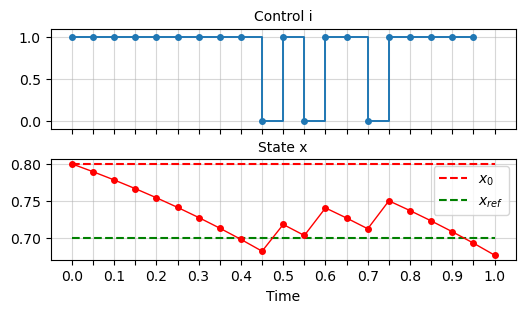

Objective value = 0.016295


In [5]:
history = optimal_control_minimization(x_0, x_ref, time, f, F, integer=True)
show(history)

### 2. Solve the corresponding relaxed problem (continuous) with GEKKO

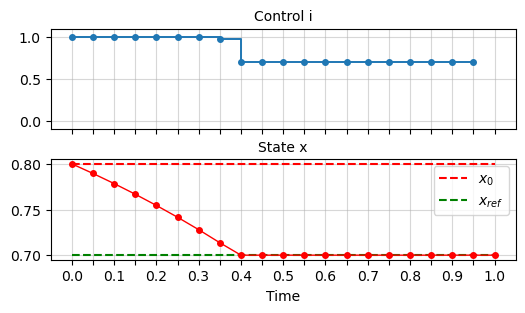

Objective value = 0.012129


In [6]:
history = optimal_control_minimization(x_0, x_ref, time, f, F, integer=False)
show(history)

### 3. Try to substitute a particular solution 

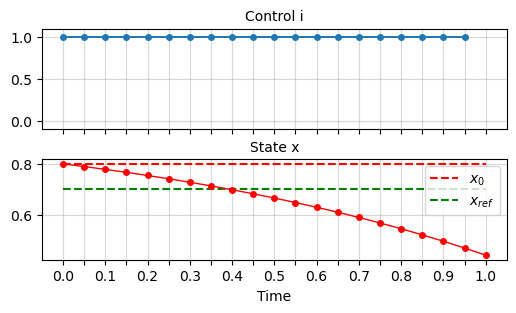

Objective value = 0.143637


In [7]:
const_i = [1] * (N + 1)
history = optimal_control_substituting(x_0, x_ref, time, f, F, const_i=const_i)
show(history)

### 4. Proposed method

Let's consider the binary vector $\textbf{i}$ as a random vector of independent random variables, where each variable $i(k)$ is Bernoulli distributed with the parameter $p_k$ (i.e. it takes the value 1 with probability $p$ and the value 0 with probability $1 - p$). To simplify further calculations a little let's write $i_k$ instead of $i(k)$

$$
\textbf{i} = 
[i_0, i_1, \dots, i_{N-1}] \sim q(\textbf{i}) = 
% q_0(i_0) \ q_1(i_1) \dots q_{N-1}(i_{N-1}) =
\prod\limits_{k=0}^{N-1} q_k(i_k), 
\quad
q_k(i) = \textbf{Bernoulli}\ (i \mid p_k)
$$


1. Sample $K$ vectors $\textbf{i}_1, \dots, \textbf{i}_K$ from $q(\textbf{i})$.
2. Compute the corresponding state trajectories $\textbf{x}_1, \dots, \textbf{x}_K$.
3. Compute the corresponding objective values $F_1, \dots, F_K = F(\textbf{x}_1, \textbf{i}_1), \dots, F(\textbf{x}_K, \textbf{i}_K)$.
4. Find $T$ best (minimal) values $F_{j_1}, \dots, F_{j_T}$ and corresponding control vectors $\textbf{i}_{j_1}, \dots, \textbf{i}_{j_T}$.
5. Update the distribution $q(\textbf{i})$ as follows:
$$
q^{new}(\textbf{i}) = 
\prod\limits_{k=0}^{N-1} q^{new}_k(i_k), 
\quad
q^{new}_k(i) = \textbf{Bernoulli}\ (i \mid p^{new}_k), 
\quad 
p^{new}_k = \frac{1}{T} \sum\limits_{t=1}^{T} \textbf{i}_{j_t}(k) - 
\text{the $k$-th component of} \ \textbf{i}_{j_t}
$$
Simply put, we update the probability of success $p_k$ according to the number of ones on the $k$-th position in the best solutions $\textbf{i}_{j_1}, \dots, \textbf{i}_{j_T}$.

6. Starting from $p_1 = \dots = p_{N-1} = 0.5$ we take $L$ steps of 1-5.

In [8]:
def sample(K, probabilities):
    """
    Sample K binary vectors from q(p_1, ..., p_{N-1})
    params: 
        K - number of samples
        probabilities - parameters p_1 ... p_{N-1}
    returns:
        I - samples
    """
    N = len(probabilities)
    I = np.random.rand(K, N)
    I = (I <= probabilities).astype(np.int32)
    return I

In [9]:
def optimal_control_custom(x_0, x_ref, time, f, F, K, T, L):
    """
    params:
        x_0 - initial state
        x_ref - final reference state  
        time - time horizon
        f - differential equation
        F - objective function
        K - number of samples
        T - number of the best solutions
        L - number of steps
    returns:
        history: a dict with
            x - predicted state trjectory of x(k)
            i - given sequense of controls i(k)
            obj_val - corresponding objective value F(x, i)
        and some other items
    """
    p = np.ones_like(time) * 0.5
    history = {'p_trace' : [p], 'obj_val_trace': []}
    
    # main iteration loop : 6
    for step in range(L):
        print('-'*100)
        print(f'Iteration {step}')
        X = []
        Obj = []
        
        # sample and substitute solutions : 1-3
        I = sample(K, p)
        for const_i in I:
            history_i = optimal_control_substituting(x_0, x_ref, time, f, F, const_i)
            X.append(history_i['x'])
            Obj.append(history_i['obj_val'])
          
        # find best solutions : 4
        top_T_id = np.argsort(Obj)[:T]
        
        # update probabilities : 5
        p = I[top_T_id].mean(0)
        
        history['obj_val_trace'].append(Obj)
        history['p_trace'].append(p)
        show_X(X, x_0, x_ref, time)
    
    best_id = np.argmin(Obj)
    history['time'] = time
    history['x'] = X[best_id]
    history['i'] = I[best_id]
    history['obj_val'] = Obj[best_id]
    history['x_0'] = x_0
    history['x_ref'] = x_ref
    history['obj_val_trace'] = np.array(history['obj_val_trace'])
    history['p_trace'] = np.array(history['p_trace'])
    return history

----------------------------------------------------------------------------------------------------
Iteration 0


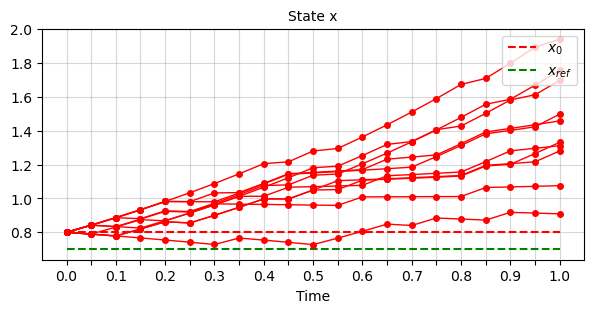

----------------------------------------------------------------------------------------------------
Iteration 1


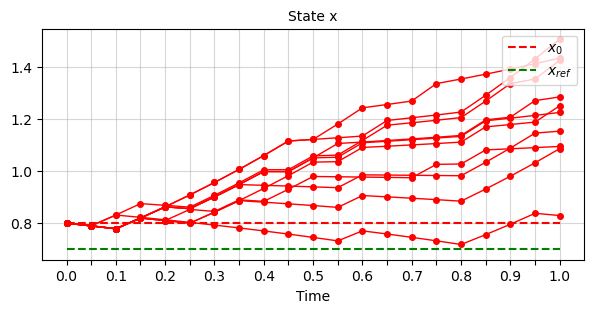

----------------------------------------------------------------------------------------------------
Iteration 2


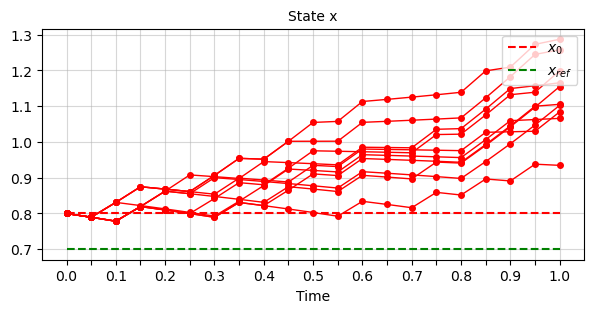

----------------------------------------------------------------------------------------------------
Iteration 3


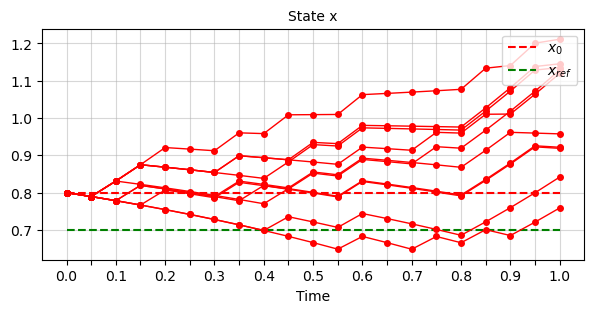

----------------------------------------------------------------------------------------------------
Iteration 4


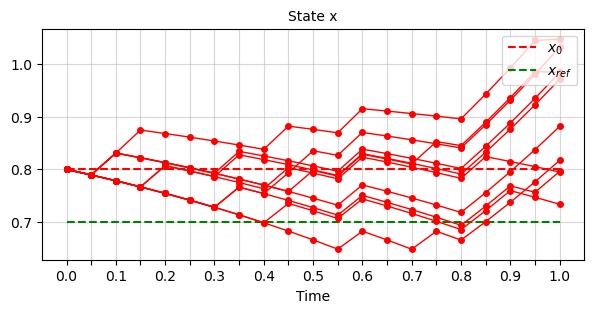

----------------------------------------------------------------------------------------------------
Iteration 5


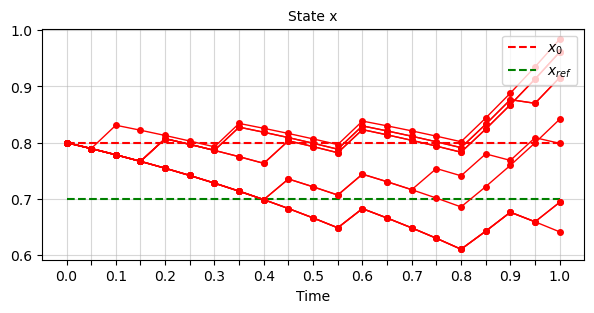

----------------------------------------------------------------------------------------------------
Iteration 6


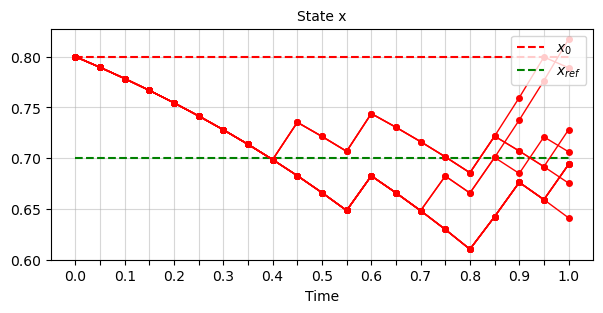

----------------------------------------------------------------------------------------------------
Iteration 7


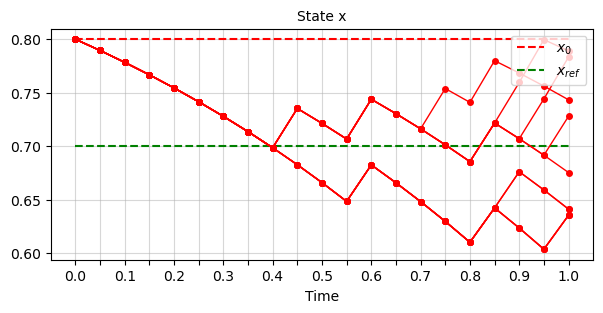

In [10]:
history = optimal_control_custom(x_0, x_ref, time, f, F, 10, 5, 8)

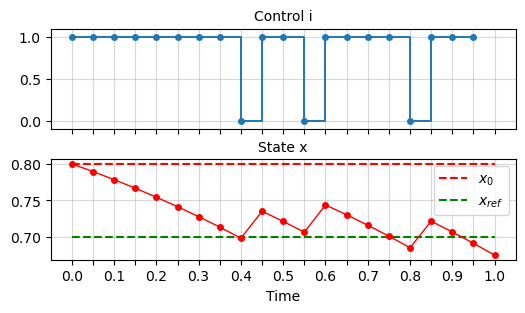

Objective value = 0.015265


In [11]:
show(history)

It's better than the GEKKO solution.

In [17]:
history['p_trace'][-1]

array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0. , 1. , 1. , 0. ,
       1. , 1. , 0.8, 1. , 0. , 0.8, 0.6, 0.6])

As we can see, the final $p_1, \dots, p_{N-1}$ are almost binary. It means that the final $q(\textbf{i})$ is almost a delta-function centered in the optimal solution $\textbf{i}^*$.

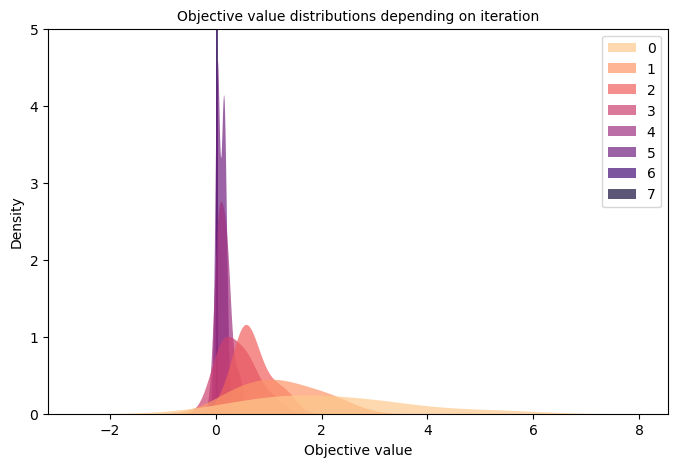

In [50]:
plt.figure(figsize=(8, 5))
plt.title('Objective value distributions depending on iteration', fontsize=10)
sns.kdeplot(
    data=history['obj_val_trace'].T,
    fill=True, common_norm=False, palette="magma_r",
    alpha=0.7, linewidth=0,
)
plt.xlabel('Objective value', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.ylim(0, 5)
plt.show()

As we can see, the distribution of objective value becames almost a delta-function centered in the minimum $F(\textbf{x}^*, \textbf{i}^*)$.